<a href="https://colab.research.google.com/github/Berk3459/CRM-Analytics-CLTV-RFM-/blob/main/crm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# **Exploratory Data Analysis (EDA)**
İlk olarak veri setini inceleyerek başlayalım

In [4]:
#veri setini yükleme
df = pd.read_csv("/content/file_out.csv.zip")
df.head(5)

,Unnamed: 0,DocumentID,Date,SKU,Price,Discount,Customer,Quantity
0,0,716,2019-09-23,1039,381.78,67.37254,1,1.0
1,1,716,2019-09-23,853,593.22,0.00034,1,1.0
2,2,716,2019-09-23,862,423.73,-0.00119,1,1.0
3,3,716,2019-09-23,868,201.70,35.58814,1,1.0
4,4,716,2019-09-23,2313,345.76,61.01966,1,1.0


In [ ]:
# Gereksiz sütunları kaldırma
df = df.drop("Unnamed: 0",axis = 1)

In [ ]:
# Zaman serisi analizi için tarih indexi oluşturma
df["Date"] = pd.to_datetime(df["Date"])
df.set_index(df["Date"], inplace = True)
df.sort_index(inplace = True)


In [ ]:
df = df.drop("Date",axis = 1)

In [ ]:
# Kolonların isimlerini güncelleme
df.rename(columns = {"DocumentID" : "InvoiceID", "SKU" : "ProductID","Price" : "TotalSales", "Customer" : "CustomerID"},inplace = True)

In [ ]:
df.shape

(33356, 7)

In [ ]:
# Veri setinin son hali
df.head(5)

,InvoiceID,Date,ProductID,TotalSales,Discount,CustomerID,Quantity
Date,,,,,,,
2019-01-01,14602,2019-01-01,2647,635.593220,114.406780,211,1.0
2019-01-02,7229,2019-01-02,371,1498.000000,269.640000,512,4.0
2019-01-02,7230,2019-01-02,130,403.889831,72.700169,57,1.0
2019-01-02,3529,2019-01-02,993,621.533898,111.876102,238,1.0
2019-01-02,66,2019-01-02,2775,1100.000000,0.000000,220,2.0


In [ ]:
# veri setindeki sütunların veri tipleri
df.dtypes

,0
InvoiceID,int64
Date,datetime64[ns]
ProductID,int64
TotalSales,float64
Discount,float64
CustomerID,int64
Quantity,float64


In [ ]:
# Eksik veri kontrolü
df.isnull().sum()

,0
InvoiceID,0
Date,0
ProductID,0
TotalSales,0
Discount,0
CustomerID,0
Quantity,0


In [ ]:
# Nümerik değerli sütunlar için özet değerler
df.describe(include = ["float64"])

,TotalSales,Discount,Quantity
count,33356.000000,33356.000000,33356.000000
mean,2915.716875,591.249968,5.760695
std,10285.512325,3508.983569,19.550559
min,0.000000,-0.004920,0.000000
25%,661.016949,95.674576,2.000000
50%,1203.389830,195.254237,4.000000
75%,2572.194915,423.489661,4.000000
max,522767.340000,240396.660000,1246.000000


In [ ]:
# toplam müşteri sayısı
df['CustomerID'].nunique()

606

**Veri Görselleştirme**

In [ ]:
df.head(5)

,InvoiceID,ProductID,TotalSales,Discount,CustomerID,Quantity
Date,,,,,,
2019-01-01,14602,2647,635.593220,114.406780,211,1.0
2019-01-02,7229,371,1498.000000,269.640000,512,4.0
2019-01-02,7230,130,403.889831,72.700169,57,1.0
2019-01-02,3529,993,621.533898,111.876102,238,1.0
2019-01-02,66,2775,1100.000000,0.000000,220,2.0


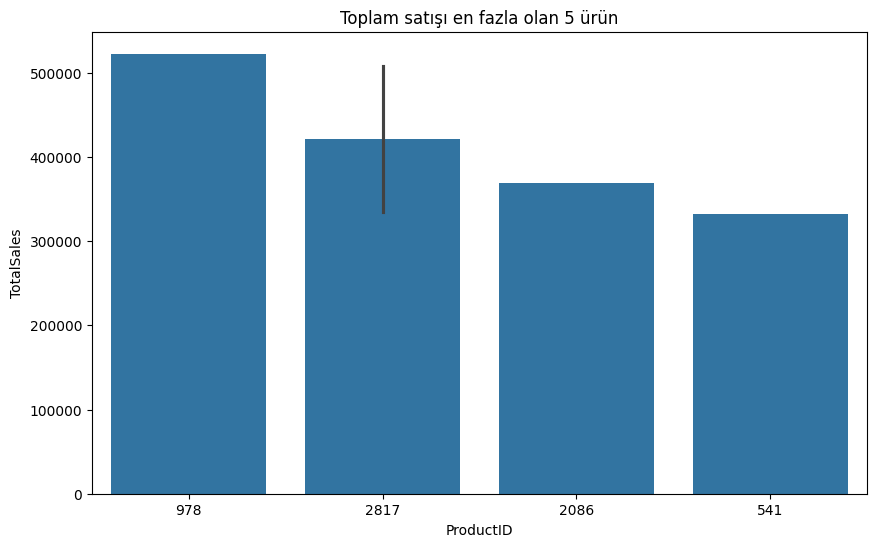

In [ ]:
top_5_sales = df.sort_values(by='TotalSales', ascending=False).reset_index(drop=True).head(5)
fig,ax = plt.subplots(figsize=(10,6))
sns.barplot(top_5_sales, x = 'ProductID',y = 'TotalSales',ax=ax)
plt.title("Toplam satışı en fazla olan 5 ürün")
plt.show()


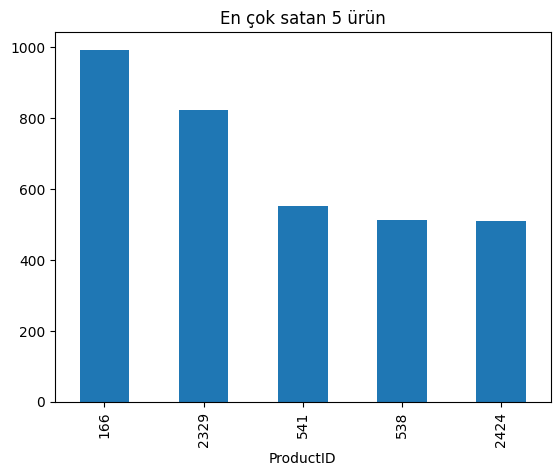

In [ ]:

df['ProductID'].value_counts().iloc[:5].plot(kind="bar",title = "En çok satan 5 ürün")

plt.show()

## RFM Analizi

RFM analizi müşterilerin değerlerini belirli metrikler kullanarak
sınıflandırır ve bu sınıflandırmalardan yola çıkarak müşteri odaklı özel stratejiler geliştirilmesine yardımcı olur.
Bu metrikler şunlardır :
Recency(R) : Yenilik,
Frequency(F) : Sıklık,
Monetary(M) : Parasal Değer

In [ ]:
# Recency değeri için baz alınan tarih
NOW = df.index.max()

In [ ]:
# Öncelikle RFM tablosu oluşturalım
rfmTable = df.groupby('CustomerID').agg({'Date': lambda x: (NOW - x.max()).days,# Recency
                                        'InvoiceID': lambda x: len(x),      # Frequency
                                        'TotalSales': lambda x: x.sum()}) # Monetary Value

rfmTable['Date'] = rfmTable['Date'].astype(int)
rfmTable.rename(columns={'Date':'Recency',
                         'InvoiceID': 'frequency',
                         'TotalSales': 'monetary_value'}, inplace=True)

In [ ]:
quartiles = rfmTable.quantile(q=[0.25,0.5,0.75])
quartiles

,Recency,frequency,monetary_value
0.25,20.0,1.00,1851.694915
0.50,157.5,4.00,8813.559322
0.75,825.0,36.75,76030.683636


In [ ]:
quartiles = quartiles.to_dict()

In [ ]:
rfmSegmentation = rfmTable

In [ ]:
# çeyreklikleri puanlandıralım
def RClass(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]:
        return 3
    else:
        return 4

# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def FMClass(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]:
        return 2
    else:
        return 1

In [ ]:
rfmSegmentation['R_Quartile'] = rfmSegmentation['Recency'].apply(RClass, args=('Recency',quartiles,))
rfmSegmentation['F_Quartile'] = rfmSegmentation['frequency'].apply(FMClass, args=('frequency',quartiles,))
rfmSegmentation['M_Quartile'] = rfmSegmentation['monetary_value'].apply(FMClass, args=('monetary_value',quartiles,))

In [ ]:
rfmSegmentation['RFMClass'] = rfmSegmentation.R_Quartile.map(str) \
                            + rfmSegmentation.F_Quartile.map(str) \
                            + rfmSegmentation.M_Quartile.map(str)

In [ ]:
rfmSegmentation['RFMClass'].value_counts()

,count
RFMClass,
111,94
444,53
344,42
243,27
222,26
211,23
434,23
122,22
322,22


In [ ]:
# en iyi 5 müşteri
rfmSegmentation[rfmSegmentation['RFMClass']=='111'].sort_values('monetary_value', ascending=False).head(5)

,Recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass
CustomerID,,,,,,,
418,4,608,7.950579e+06,1,1,1,111
359,2,588,4.293243e+06,1,1,1,111
284,0,4227,4.083301e+06,1,1,1,111
286,0,627,3.152595e+06,1,1,1,111
74,11,510,2.735580e+06,1,1,1,111


# Customer Lİfetime Value(CLTV)
Bu kısımda müşterilerin satın alma geçmişlerini inceleyerek bize gelecekte ne kadar kâr getireceğini ,hangi müşterilere daha çok kampanya yapılması gerektiğini ve en çok kâr getiren müşterileri kaybetmemek için neler yapılabileceğini inceleyeceğiz.

In [ ]:
!pip install lifetimes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.2/584.2 kB 9.2 MB/s eta 0:00:00


In [ ]:
from sklearn.preprocessing import MinMaxScaler
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter

kuracağımız clv modelinin doğru bir şekilde müşteri segmentasyonu yapabilmesi için aykırı değerleri gidermemiz gerekiyor

In [ ]:
df[['Quantity','TotalSales']].describe([0.05,0.10,0.25,0.50,0.80,0.95,0.99]).T

,count,mean,std,min,5%,10%,25%,50%,80%,95%,99%,max
Quantity,33356.0,5.760695,19.550559,0.0,1.0000,1.000000,2.000000,4.00000,6.000000,18.000000,50.000000,1246.00
TotalSales,33356.0,2915.716875,10285.512325,0.0,111.8175,281.779661,661.016949,1203.38983,3220.338983,9144.914661,26101.697203,522767.34


In [ ]:
# Görüldüğü gibi her iki değişkendede %99luk ve max değerler arasında büyük fark var
# outlier_thresholds fonksiyonu ile aykırı değerler için bir eşik değer belirliyoruz.
# Alt ve Üst sınır olarak bir eşik değer belirliyoruz. Bu aykırı gözlemler eşik değerin dışında kalıyor.
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [ ]:
# replace_with_thresholds fonksiyonunda ise aykırı olan değerleri outlier_thresholds fonksiyonunda saptadığımız eşik değerlerle değiştiriyoruz.
# Yani aykırı değerler artık bizim belirlediğimiz çeyreklikte eşik değerlerle değişmiş oluyor.
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [ ]:
replace_with_thresholds(df, "Quantity")
replace_with_thresholds(df, "TotalSales")

In [ ]:
df[['Quantity','TotalSales']].describe([0.05,0.10,0.25,0.50,0.80,0.95,0.99]).T

,count,mean,std,min,5%,10%,25%,50%,80%,95%,99%,max
Quantity,33356.0,5.412422,9.022493,0.0,1.0000,1.000000,2.000000,4.00000,6.000000,18.000000,50.000000,125.000000
TotalSales,33356.0,2682.837656,5519.917495,0.0,111.8175,281.779661,661.016949,1203.38983,3220.338983,9144.914661,26101.697203,65254.243008


In [ ]:
rfmSegmentation['avg_order_value'] = rfmSegmentation['monetary_value'] / rfmSegmentation['frequency']

In [ ]:
rfmSegmentation["purchase_frequency"] = rfmSegmentation['frequency'] / rfmSegmentation.shape[0]

In [ ]:
rfmSegmentation['profit_margin'] = rfmSegmentation['monetary_value'] * 0.05

In [ ]:
# Veri setinde en az 1 kere alışveriş yapan müşteri sayısı / tüm müşteri sayısı
repeat_rate = rfmSegmentation[rfmSegmentation.frequency > 1].shape[0] / rfmSegmentation.shape[0]
churn_rate = 1 - repeat_rate

In [ ]:
# Customer Value
rfmSegmentation['cv'] = (rfmSegmentation['avg_order_value'] * rfmSegmentation["purchase_frequency"])


In [ ]:
rfmSegmentation['cltv'] = (rfmSegmentation['cv'] / churn_rate) * rfmSegmentation['profit_margin']

In [ ]:
rfmSegmentation.head()

,Recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass,avg_order_value,purchase_frequency,profit_margin,cv,cltv
CustomerID,,,,,,,,,,,,
0,0,19,101061.254237,1,2,1,121,5319.013381,0.031353,5053.062712,166.767746,2.540641e+06
1,599,181,123904.710850,3,1,1,311,684.556414,0.298680,6195.235543,204.463219,3.818999e+06
2,61,35,43406.084743,2,2,2,222,1240.173850,0.057756,2170.304237,71.627203,4.686787e+05
3,10,2,5261.605763,1,3,3,133,2630.802881,0.003300,263.080288,8.682518,6.886690e+03
4,13,111,744094.573008,1,1,1,111,6703.554712,0.183168,37204.728650,1227.878833,1.377305e+08


In [ ]:
# MinMaxScaler
# Bulduğumuz CLTV değerini daha kolay okumak adına 1-100 arası puanlıyoruz.
# cltv_c adında yeni bir değişkene atıyoruz.Calculate edilmiş cltv değerine erişiyoruz.
scaler = MinMaxScaler(feature_range=(1, 100))
scaler.fit(rfmSegmentation[["cltv"]])
rfmSegmentation["cltv_c"] = scaler.transform(rfmSegmentation[["cltv"]])

In [ ]:
# Hesapladığımız müşteri yaşam boyu değerine göre müşterilerimizi segmentlere ayırdık.
rfm_cltv.sort_values(by="cltv_c", ascending=False).head()